<a href="https://colab.research.google.com/github/EngelMichael/FRA_UAS_AI_recognition_Project/blob/main/AI_Classifier_FRA_UAS_Informatik_Projekt_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accessable Hardware

In [1]:
!nvidia-smi
# for training a GPU with at least 15GB of VRAM is required
# for less available VRAM the batch size set to 32 has to be reduced

Mon Feb 10 17:23:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Setup

In [2]:
# installing basic ML and datamanipulating packages
%%capture
!pip install transformers
!pip install pytorch-lightning
!pip install datasets
!pip install wandb
import pandas as pd

In [3]:
# loading an open dataset containing data scraped from reddit
# it contain human written and GPT 3.5 written labelled text
from datasets import load_dataset

ds = load_dataset("Hello-SimpleAI/HC3", "all")

# https://huggingface.co/datasets/Hello-SimpleAI/HC3


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

HC3.py:   0%|          | 0.00/9.47k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/39.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24322 [00:00<?, ? examples/s]

In [4]:
# inspecting downloaded datastructure
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'human_answers', 'chatgpt_answers', 'source'],
        num_rows: 24322
    })
})

In [5]:

from datasets import load_dataset
from sklearn.model_selection import train_test_split
import pandas as pd

def load_and_split_dataset(dataset_name, dataset_config, train_size=0.6, val_size=0.2, test_size=0.2, seed=42):
    """Loads a dataset from Hugging Face and splits it into train, validation, and test sets
       with specified proportions.

    Args:
        dataset_name: Name of the dataset on Hugging Face.
        dataset_config: Configuration name for the dataset.
        train_size: Proportion of the dataset to use for training.
        val_size: Proportion of the dataset to use for validation.
        test_size: Proportion of the dataset to use for testing.
        seed: Random seed for reproducibility.

    Returns:
        A tuple containing the train, validation, and test pandas DataFrames.
    """
    # Load the dataset
    ds = load_dataset(dataset_name, dataset_config)

    # Ensure that the train, val, and test sizes add up to 1
    if train_size + val_size + test_size != 1.0:
        raise ValueError("Train, validation, and test sizes must add up to 1.")

    # Split the dataset into train+validation and test sets
    train_val_ds = ds["train"].train_test_split(test_size=test_size, seed=seed)

    # Split the train+validation set into train and validation sets
    # Calculate the relative size of the validation set compared to the train+val set
    relative_val_size = val_size / (train_size + val_size)
    train_ds = train_val_ds["train"].train_test_split(test_size=relative_val_size, seed=seed)


    # The test set will be the remainder from the initial split
    test_ds = train_val_ds["test"]


    # Convert to pandas DataFrames
    train_df = pd.DataFrame(train_ds["train"])
    val_df = pd.DataFrame(train_ds["test"])
    test_df = pd.DataFrame(test_ds)

    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")

    return train_df, val_df, test_df

In [6]:
# Usage
dataset_name = "Hello-SimpleAI/HC3"
dataset_config = "all"
train_df, val_df, test_df = load_and_split_dataset(dataset_name, dataset_config, train_size=0.6, val_size=0.2, test_size=0.2)

Training set size: 14592
Validation set size: 4865
Test set size: 4865


# Inspect Data
Here we calculate some measurements about our data and take a first look how the text is formatted and if some formating remnants need to be removed.
Also whether the size of the individual training data isn't to big (on average) because RoBERTa has a limited context size 512 tokens.

In [7]:
train_df

,id,question,human_answers,chatgpt_answers,source
0,15266,How does lack of sleep lead to bags under the ...,[its just the small muscles around the eyes be...,"[Sure! When we sleep, our bodies go through a ...",reddit_eli5
1,10364,Do expensive sunglasses like Oakleys actually ...,[The answers here are all over the place . Yes...,[],reddit_eli5
2,11047,Why is Facebook buying Oculus such a bad thing...,"[Because typically , when a large , unrelated ...",[There are a few reasons why some people are u...,reddit_eli5
3,808,"When sworn to tell "" the truth , the whole tru...","[In the US , the [ Fifth Amendment ] ( URL_0 )...","[In a criminal trial, the defendant is conside...",reddit_eli5
4,2065,What the heck the Pirate Party is . The heck ?...,[Every political party in the world has some a...,[The Pirate Party is a political party that ad...,reddit_eli5
...,...,...,...,...,...
14587,21532,Is a real estate attorney needed for builder d...,[You need to let a lawyer look at it. Concern...,[It is generally a good idea to consult with a...,finance
14588,13363,Why are dog years shorter than human years ? H...,[Dog years is made up . Dogs just have a short...,[Dog years are not actually shorter than human...,reddit_eli5
14589,22011,How long does a bank's “Know Your Customer” (K...,[The idea is to positively identify you with p...,[The length of a bank's Know Your Customer (KY...,finance
14590,4464,What happens when smokers become tolerant of i...,[Two things happen to the cells lining your tr...,"[When people smoke cigarettes, they inhale the...",reddit_eli5


In [8]:
train_df.head(20)

,id,question,human_answers,chatgpt_answers,source
0,15266,How does lack of sleep lead to bags under the ...,[its just the small muscles around the eyes be...,"[Sure! When we sleep, our bodies go through a ...",reddit_eli5
1,10364,Do expensive sunglasses like Oakleys actually ...,[The answers here are all over the place . Yes...,[],reddit_eli5
2,11047,Why is Facebook buying Oculus such a bad thing...,"[Because typically , when a large , unrelated ...",[There are a few reasons why some people are u...,reddit_eli5
3,808,"When sworn to tell "" the truth , the whole tru...","[In the US , the [ Fifth Amendment ] ( URL_0 )...","[In a criminal trial, the defendant is conside...",reddit_eli5
4,2065,What the heck the Pirate Party is . The heck ?...,[Every political party in the world has some a...,[The Pirate Party is a political party that ad...,reddit_eli5
5,19151,Why does the Brexit cause a fall in crude oil ...,[Uncertainty has very far reaching effects. ...,"[The Brexit, or the United Kingdom's withdrawa...",finance
6,2325,Life Insurance Why is life insurance better th...,[Let 's say you have a family . Your family ha...,[Life insurance is a type of insurance that pa...,reddit_eli5
7,1652,can someone explain how a programing language ...,[This has been touched upon in other topics ab...,[Sure! I'd be happy to explain how a programmi...,reddit_eli5
8,16989,Why does the u.s . have such large coffee size...,[American companies are very competitive with ...,"[In the United States, coffee sizes at places ...",reddit_eli5
9,22491,Is there a law or regulation that governs the ...,"[In the EU, you might be looking for Directive...",[There are laws and regulations that place lim...,finance


In [9]:
# viewing cleaned data in a raw format to see if some formatting remnants
# do not show up in google spreadsheet
for column in ['human_answers', 'chatgpt_answers']:
    print(f"Column: {column}")  # Print the column name for clarity
    for text in train_df.head(20)[column]:
        print(repr(text))
    print("-" * 20)  # Print a separator between columns

Column: human_answers
['its just the small muscles around the eyes being tired . Those fuckers move almost constantly throughout the day , so when they get tired they really look tired .', 'Bags under your eyes can also be increased in size if you eat a lot of salt thru the day .', "Actually , it 's kind of the other way around . The skin on your face gets pale from a lack of sleep or just general fatigue , and as a result , it seems as if you have these dark circles under your eyes ."]
['The answers here are all over the place . Yes , you are paying for name / marketing , but you are also paying for correctly oriented polarized lenses . There is also UV protection , but you can find that on cheap pairs too . What makes Oakleys preferable is that the polarized lenses ( which reduce glare ) are oriented in the same direction . If they are not oriented the same direction , your brain will have difficulty correcting the slight distortions , which will eventually make it uncomfortable to w

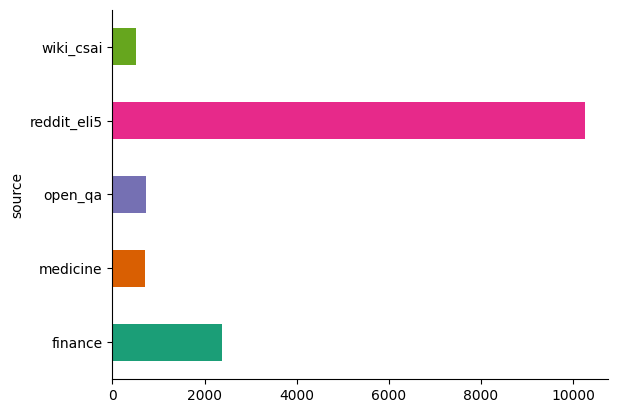

In [10]:
# @title source training

from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('source').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [11]:
val_df.head()

,id,question,human_answers,chatgpt_answers,source
0,23877,Are there any supplements to help the brain he...,"[during coiling procedure, developing stroke i...",[It is important to consult with a medical pro...,medicine
1,13778,Can we use this new rail gun technology to sho...,"[Technically speaking , yes we could probably ...",[A rail gun is a device that uses electricity ...,reddit_eli5
2,16156,what an algorithm is . I 've heard about it fo...,[An algorithm is a series of steps to do somet...,[An algorithm is a set of instructions that te...,reddit_eli5
3,5006,Why Facebook may finally have to compromise it...,[So Facebook has grown ( in terms of money ) u...,[\nSure! I'd be happy to help explain this art...,reddit_eli5
4,2100,Refrigeration How does electronic power effect...,[The electricity turns a fan . The fan carries...,[Sure! Refrigeration is a way to keep things c...,reddit_eli5


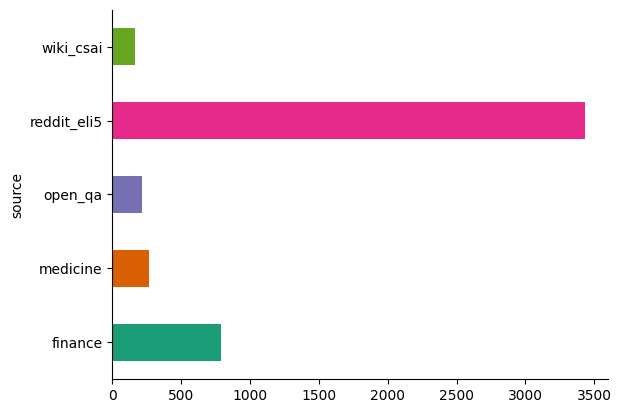

In [12]:
# @title source validation

from matplotlib import pyplot as plt
import seaborn as sns
val_df.groupby('source').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
avg_human_symbols = train_df['human_answers'].apply(lambda x: sum(len(s) for s in x)).mean()
avg_question_symbols = train_df['question'].apply(lambda x: sum(len(s) for s in x)).mean()
avg_chatgpt_symbols = train_df['chatgpt_answers'].apply(lambda x: sum(len(s) for s in x)).mean()

print(f"Average number of symbols in 'human_answers': {avg_human_symbols}")
print(f"Average number of symbols in 'chatgpt_answers': {avg_chatgpt_symbols}")
print(f"Average number of symbols in 'question': {avg_question_symbols}")


Average number of symbols in 'human_answers': 1644.5503015350878
Average number of symbols in 'chatgpt_answers': 1119.711485745614
Average number of symbols in 'question': 165.12342379385964


In [14]:
import numpy as np
def median_symbols(df, column_name):
    """Calculates the median number of symbols in a column.

    Args:
        df: The input DataFrame.
        column_name: The name of the column to calculate the median for.

    Returns:
        The median number of symbols in the specified column.
    """
    symbol_lengths = df[column_name].apply(lambda x: sum(len(s) for s in x))
    median_length = np.median(symbol_lengths)
    return median_length

# Calculate median symbol lengths for each column
median_human_symbols = median_symbols(train_df, 'human_answers')
median_question_symbols = median_symbols(train_df, 'question')
median_chatgpt_symbols = median_symbols(train_df, 'chatgpt_answers')

# Print the results
print(f"Median number of symbols in 'human_answers': {median_human_symbols}")
print(f"Median number of symbols in 'chatgpt_answers': {median_chatgpt_symbols}")
print(f"Median number of symbols in 'question': {median_question_symbols}")


Median number of symbols in 'human_answers': 1236.0
Median number of symbols in 'chatgpt_answers': 1061.0
Median number of symbols in 'question': 172.0


# Regular Expression Data cleaning
In this step we remove formatting remnants of the webscraping process.
Examples are *\n \*r etc.
This step is not perfect and could use further improvement.

In [ ]:
import re

def clean_text(text):
  """Cleans text by removing formatting remnants like \n [""] [''].
      In its current form not removing URL remnants like (URL_1)
  Args:
    text: The input text string.

  Returns:
    The cleaned text string.
  """

  # Modified regex to handle optional quotes at the beginning
  text = re.sub(r'^\[?["\']?', '', text)
  # Modified regex to handle optional quotes at the end
  text = re.sub(r'["\']?\]?$', '', text)

  # Remove single or double quotes only at the beginning and end
  text = re.sub(r'^["\']', '', text)  # Remove at the beginning
  text = re.sub(r'["\']$', '', text)  # Remove at the end



  text = re.sub(r"\\n", " ", text)  # Replaces '\n' with a space
  text = re.sub(r"\\r", " ", text)  # Replaces '\r' with a space
  text = re.sub(r"\\u", " ", text)  # Replaces '\u' with a space

  text = re.sub(r'\\', '', text) # Remove backslashes

    # Remove backslashes (including escaped ones)
  text = re.sub(r'\\\\', '', text)  # Matches escaped backslashes (\\)

  text = re.sub(r"\s+", " ", text)  # Replaces multiple spaces with a single space
  text = text.strip()  # Removes leading/trailing spaces

  return text


In [ ]:
# Re only works on strings so we need to convert the data format
print(train_df.dtypes)

id                 object
question           object
human_answers      object
chatgpt_answers    object
source             object
dtype: object


In [ ]:
train_df['human_answers'] = train_df['human_answers'].astype('string')
train_df['chatgpt_answers'] = train_df['chatgpt_answers'].astype('string')

In [ ]:
# iterating through each column and row in human_ answers and chatgpt_answers
# and applying RegEx cleaning function
for column in ['human_answers', 'chatgpt_answers']:
    train_df[column] = train_df[column].apply(clean_text) #applyng cleaning function to every element in the dataframe

In [ ]:
# For val_df
val_df['human_answers'] = val_df['human_answers'].astype('string')
val_df['chatgpt_answers'] = val_df['chatgpt_answers'].astype('string')
for column in ['human_answers', 'chatgpt_answers']:
    val_df[column] = val_df[column].apply(clean_text)

# For test_df
test_df['human_answers'] = test_df['human_answers'].astype('string')
test_df['chatgpt_answers'] = test_df['chatgpt_answers'].astype('string')
for column in ['human_answers', 'chatgpt_answers']:
    test_df[column] = test_df[column].apply(clean_text)

In [ ]:
# inspecting cleaned data
train_df.head(30)

,id,question,human_answers,chatgpt_answers,source
0,15266,How does lack of sleep lead to bags under the ...,its just the small muscles around the eyes bei...,"Sure! When we sleep, our bodies go through a p...",reddit_eli5
1,10364,Do expensive sunglasses like Oakleys actually ...,The answers here are all over the place . Yes ...,,reddit_eli5
2,11047,Why is Facebook buying Oculus such a bad thing...,"Because typically , when a large , unrelated c...",There are a few reasons why some people are up...,reddit_eli5
3,808,"When sworn to tell "" the truth , the whole tru...","In the US , the [ Fifth Amendment ] ( URL_0 ) ...","In a criminal trial, the defendant is consider...",reddit_eli5
4,2065,What the heck the Pirate Party is . The heck ?...,Every political party in the world has some af...,The Pirate Party is a political party that adv...,reddit_eli5
5,19151,Why does the Brexit cause a fall in crude oil ...,Uncertainty has very far reaching effects. Oil...,"The Brexit, or the United Kingdom's withdrawal...",finance
6,2325,Life Insurance Why is life insurance better th...,Let 's say you have a family . Your family has...,Life insurance is a type of insurance that pay...,reddit_eli5
7,1652,can someone explain how a programing language ...,This has been touched upon in other topics abo...,Sure! I'd be happy to explain how a programmin...,reddit_eli5
8,16989,Why does the u.s . have such large coffee size...,American companies are very competitive with o...,"In the United States, coffee sizes at places l...",reddit_eli5
9,22491,Is there a law or regulation that governs the ...,"In the EU, you might be looking for Directive ...",There are laws and regulations that place limi...,finance


In [ ]:
# viewing cleaned data in a raw format to see if some formatting remnants
# do not show up in google spreadsheet
for column in ['human_answers', 'chatgpt_answers']:
    print(f"Column: {column}")  # Print the column name for clarity
    for text in train_df.head(20)[column]:
        print(repr(text))
    print("-" * 20)  # Print a separator between columns

Column: human_answers
'its just the small muscles around the eyes being tired . Those fuckers move almost constantly throughout the day , so when they get tired they really look tired .\', \'Bags under your eyes can also be increased in size if you eat a lot of salt thru the day .\', "Actually , it \'s kind of the other way around . The skin on your face gets pale from a lack of sleep or just general fatigue , and as a result , it seems as if you have these dark circles under your eyes .'
'The answers here are all over the place . Yes , you are paying for name / marketing , but you are also paying for correctly oriented polarized lenses . There is also UV protection , but you can find that on cheap pairs too . What makes Oakleys preferable is that the polarized lenses ( which reduce glare ) are oriented in the same direction . If they are not oriented the same direction , your brain will have difficulty correcting the slight distortions , which will eventually make it uncomfortable to 

In [ ]:
val_df.head(20)
for column in ['human_answers', 'chatgpt_answers']:
    print(f"Column: {column}")  # Print the column name for clarity
    for text in val_df.head(20)[column]:
        print(repr(text))
    print("-" * 20)  # Print a separator between columns

Column: human_answers
'during coiling procedure, developing stroke is a known complication. the symptoms depend on which areas of brain got affacted by stroke.there is not much effective supplement to restore menory/brain heal. Still few studies suggest use of tab piracetam , tab citicholine to boost the recovery.'
'Technically speaking , yes we could probably shoot things into space with rail guns . I do n\'t know if it would be even remotely cost effective , but it could probably be done . The concept of " mass drivers " originally refereed to this idea , and it \'s one that gets tossed around quite a bit in science fiction . However , the problem is that whatever we \'d be shooting into space would almost certainly be destroyed . The acceleration of things being fired via rail gun is massive . I think I read somewhere that the production model used by the navy is supposed to hit something like mach 20 . It works for weapons because you \'re just hitting a target with a piece of meta

In [ ]:
test_df.head(20)
for column in ['human_answers', 'chatgpt_answers']:
    print(f"Column: {column}")  # Print the column name for clarity
    for text in test_df.head(20)[column]:
        print(repr(text))
    print("-" * 20)  # Print a separator between columns

Column: human_answers
'An ordinary boiler works like this : fuel is burned in a combustion chamber . Water runs through this combustion chamber in many small , winding pipes ( a construction called a " heat exchanger " ) , which is how the water is heated . This works pretty well , and you can extract most of the heat gained from burning the fuel this way . However , some heat that \'s pretty hard to extract in a normal setup is heat that \'s * stored in the water in the exhaust * . When you burn fuel , the products of that reaction ( assuming complete combustion - so no unburnt fuel ) are mostly carbon dioxide and water ( along with other products that depend mostly on the temperature of the combustion process and the exhaust , like carbon monoxide , nitrous oxide , and other , weirder products ) . Now that water , since it \'s very hot , is produced in gaseous form ( as water vapor ) , not liquid water . That means that there \'s a significant amount of heat still trapped in that wat

# Mounting to Google Drive
Because google collab has ephemeral storage everything that should be persistant needs to be stored locally or on google drive.
We choose the drive so its not bound to user hardware.

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Serializing to CSV format for storage
train_df.to_csv('/content/drive/MyDrive/train_df.csv', index=False)

In [ ]:
# Deserialization
# Load the CSV file from Google Drive into a pandas DataFrame
train_df_loaded = pd.read_csv('/content/drive/MyDrive/train_df.csv')

# Inspecting data whether serialization & deserialization changed the data
# observation: empty datapoints got converted to NULL, should not be a problem
train_df_loaded.head()

,id,question,human_answers,chatgpt_answers,source
0,15266,How does lack of sleep lead to bags under the ...,its just the small muscles around the eyes bei...,"Sure! When we sleep, our bodies go through a p...",reddit_eli5
1,10364,Do expensive sunglasses like Oakleys actually ...,The answers here are all over the place . Yes ...,NaN,reddit_eli5
2,11047,Why is Facebook buying Oculus such a bad thing...,"Because typically , when a large , unrelated c...",There are a few reasons why some people are up...,reddit_eli5
3,808,"When sworn to tell "" the truth , the whole tru...","In the US , the [ Fifth Amendment ] ( URL_0 ) ...","In a criminal trial, the defendant is consider...",reddit_eli5
4,2065,What the heck the Pirate Party is . The heck ?...,Every political party in the world has some af...,The Pirate Party is a political party that adv...,reddit_eli5


In [ ]:
train_df.head()

,id,question,human_answers,chatgpt_answers,source
0,15266,How does lack of sleep lead to bags under the ...,its just the small muscles around the eyes bei...,"Sure! When we sleep, our bodies go through a p...",reddit_eli5
1,10364,Do expensive sunglasses like Oakleys actually ...,The answers here are all over the place . Yes ...,,reddit_eli5
2,11047,Why is Facebook buying Oculus such a bad thing...,"Because typically , when a large , unrelated c...",There are a few reasons why some people are up...,reddit_eli5
3,808,"When sworn to tell "" the truth , the whole tru...","In the US , the [ Fifth Amendment ] ( URL_0 ) ...","In a criminal trial, the defendant is consider...",reddit_eli5
4,2065,What the heck the Pirate Party is . The heck ?...,Every political party in the world has some af...,The Pirate Party is a political party that adv...,reddit_eli5


**Raw format test:** checking whether saving to drive as csv changes the file -> empty blocks are saved as "nan" instead of ""

In [ ]:
#checking whether saving ro drive as csv changes the file
for column in ['human_answers', 'chatgpt_answers']:
    print(f"Column: {column}")  # Print the column name for clarity
    for text in train_df.head(5)[column]:
        print(repr(text))
    print("-" * 20)  # Print a separator between columns

Column: human_answers
'its just the small muscles around the eyes being tired . Those fuckers move almost constantly throughout the day , so when they get tired they really look tired .\', \'Bags under your eyes can also be increased in size if you eat a lot of salt thru the day .\', "Actually , it \'s kind of the other way around . The skin on your face gets pale from a lack of sleep or just general fatigue , and as a result , it seems as if you have these dark circles under your eyes .'
'The answers here are all over the place . Yes , you are paying for name / marketing , but you are also paying for correctly oriented polarized lenses . There is also UV protection , but you can find that on cheap pairs too . What makes Oakleys preferable is that the polarized lenses ( which reduce glare ) are oriented in the same direction . If they are not oriented the same direction , your brain will have difficulty correcting the slight distortions , which will eventually make it uncomfortable to 

In [ ]:
for column in ['human_answers', 'chatgpt_answers']:
    print(f"Column: {column}")  # Print the column name for clarity
    for text in train_df_loaded.head(5)[column]:
        print(repr(text))
    print("-" * 20)  # Print a separator between columns

Column: human_answers
'its just the small muscles around the eyes being tired . Those fuckers move almost constantly throughout the day , so when they get tired they really look tired .\', \'Bags under your eyes can also be increased in size if you eat a lot of salt thru the day .\', "Actually , it \'s kind of the other way around . The skin on your face gets pale from a lack of sleep or just general fatigue , and as a result , it seems as if you have these dark circles under your eyes .'
'The answers here are all over the place . Yes , you are paying for name / marketing , but you are also paying for correctly oriented polarized lenses . There is also UV protection , but you can find that on cheap pairs too . What makes Oakleys preferable is that the polarized lenses ( which reduce glare ) are oriented in the same direction . If they are not oriented the same direction , your brain will have difficulty correcting the slight distortions , which will eventually make it uncomfortable to 

# Converting Data to RoBertA-readable format (Hugginface-format)
We remove the not necessary coloums in our data and add a coloumn *label*. In this column we label the data with 1 / 0 for Human / AI written.
The table looks like:

 **text** | **label**

sample0 | 1

sample1 | 0

.

.

.


Till now we worked with the pandas data format since it specialises on editing and viewing data. For use in training we need a hugging face compatible dataformat (dataset format) to which we convert at the end.

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive') # must be executed every reset!

# Load the CSV file from Google Drive into a pandas DataFrame
train_df_loaded = pd.read_csv('/content/drive/MyDrive/train_df.csv')

Mounted at /content/drive


In [ ]:
import pandas as pd

human_df = pd.DataFrame({
    'text': train_df_loaded['human_answers'].dropna(),  # Drop rows with missing human answers
    'label': 1  # Assign label 1 for human answers
})
human_df.head()

,text,label
0,its just the small muscles around the eyes bei...,1
1,The answers here are all over the place . Yes ...,1
2,"Because typically , when a large , unrelated c...",1
3,"In the US , the [ Fifth Amendment ] ( URL_0 ) ...",1
4,Every political party in the world has some af...,1


In [ ]:
chatgpt_df = pd.DataFrame({
    'text': train_df_loaded['chatgpt_answers'].dropna(),  # Drop rows with missing ChatGPT answers
    'label': 0  # Assign label 0 for ChatGPT answers
})
chatgpt_df.head()

,text,label
0,"Sure! When we sleep, our bodies go through a p...",0
2,There are a few reasons why some people are up...,0
3,"In a criminal trial, the defendant is consider...",0
4,The Pirate Party is a political party that adv...,0
5,"The Brexit, or the United Kingdom's withdrawal...",0


In [ ]:
new_df = pd.concat([human_df, chatgpt_df], ignore_index=True)
new_df.head(20)
label_counts = new_df['label'].value_counts()
print(label_counts)

label
1    14592
0    14323
Name: count, dtype: int64


In [ ]:
!pip install datasets # Makes sure that the 'datasets' library is installed.
from datasets import Dataset # Imports the 'Dataset' class from the 'datasets' library.

dataset = Dataset.from_pandas(new_df) # hugging face data format

# 1. Basic Information:
print(dataset)  # Prints basic info like number of rows, columns, and dataset type
print(dataset.features) # Shows the data types of each column
print(dataset.num_rows) # Prints the number of rows in the dataset
print(dataset.column_names) # Prints the names of the columns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Dataset({
    features: ['text', 'label'],
    num_rows: 28915
})
{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}
28915
['text', 

# Training
We connect the drive with our collab to import the training data aswell as save the checkpoint file with the weights and biases at the end.
Since this is the place where the data gets usually split into training and validation we do it again. Beecause of this we have less data than we could have but this is still plenty for this usecase. As an advantage we have data that the model has never see in the split before which we can use to further test our model.

The training is tuned to a T4 TPU with ~15 GB of VRAM. If less VRAM is available, the batchsize has to be reduced. On average 1 epoch with these settings takes 35 min. of training time.

For multiple epochs the best in terms of validations loss is choosen and saved.

For training analysis the website wandb.ai is used. Its build in in the Huggingface trainer and logs the training stats on its website once its connected to the usercreated API key.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install required libraries
!pip install transformers datasets torch

from datasets import DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# TODO: move to convrt and save in drive, add fixed seed
# Split dataset into train and validation sets
dataset = dataset.train_test_split(test_size=0.2)
train_dataset = dataset['train']
val_dataset = dataset['test']

# Load the RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Tokenization function
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# Load the RoBERTa model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Define a compute metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)  # Convert logits to predicted class
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32, # Decrease for less VRAM usage
    per_device_eval_batch_size=32,  # Decrease for less VRAM usage
    num_train_epochs=10,  # Increase epochs for better performance
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,  # Save and load the best model based on validation loss
    metric_for_best_model="eval_loss",
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # Add the custom metrics function here
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)

# Save the trained model and tokenizer on collab (ephemeral)
model.save_pretrained("./model")
tokenizer.save_pretrained("./model")


# Save the trained model and tokenizer on google drive
model.save_pretrained('/content/drive/MyDrive/roberta_model')
tokenizer.save_pretrained('/content/drive/MyDrive/roberta_model')



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/23132 [00:00<?, ? examples/s]

Map:   0%|          | 0/5783 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-746fc62321fb>:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.002600,0.011539,0.997579,0.999658,0.995568,0.997608
2,0.025200,0.162203,0.976829,1.000000,0.954313,0.976622
3,0.028300,0.012347,0.998271,1.000000,0.996591,0.998292
4,0.000000,0.090520,0.987550,1.000000,0.975452,0.987573
5,0.000000,0.093019,0.985302,1.000000,0.971019,0.985297
6,0.000000,0.037325,0.995677,1.000000,0.991476,0.995720


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.002600,0.011539,0.997579,0.999658,0.995568,0.997608
2,0.025200,0.162203,0.976829,1.000000,0.954313,0.976622
3,0.028300,0.012347,0.998271,1.000000,0.996591,0.998292
4,0.000000,0.090520,0.987550,1.000000,0.975452,0.987573
5,0.000000,0.093019,0.985302,1.000000,0.971019,0.985297
6,0.000000,0.037325,0.995677,1.000000,0.991476,0.995720
7,0.000000,0.039173,0.995158,1.000000,0.990453,0.995204
8,0.016400,0.033612,0.996023,1.000000,0.992158,0.996064
9,0.000000,0.022635,0.997406,1.000000,0.994886,0.997436
10,0.000000,0.036766,0.995504,1.000000,0.991135,0.995548


Evaluation Results: {'eval_loss': 0.01153864711523056, 'eval_accuracy': 0.9975791111879647, 'eval_precision': 0.999657651489216, 'eval_recall': 0.9955676781452438, 'eval_f1': 0.9976084728390844, 'eval_runtime': 169.8345, 'eval_samples_per_second': 34.051, 'eval_steps_per_second': 1.066, 'epoch': 10.0}


('/content/drive/MyDrive/roberta_model/tokenizer_config.json',
 '/content/drive/MyDrive/roberta_model/special_tokens_map.json',
 '/content/drive/MyDrive/roberta_model/vocab.json',
 '/content/drive/MyDrive/roberta_model/merges.txt',
 '/content/drive/MyDrive/roberta_model/added_tokens.json',
 '/content/drive/MyDrive/roberta_model/tokenizer.json')

# Inference
The inference can now be executed with the training parameters.

As an input it takes a text string and as an output it gives back the probabilitys of the input text beeing Human or AI generated.

A GPU is not needed for this step.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/roberta_model')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/roberta_model')


In [ ]:
#from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load the trained model and tokenizer from collab (ephemeral)
#model = AutoModelForSequenceClassification.from_pretrained("./model")
#tokenizer = AutoTokenizer.from_pretrained("./model")

# Function to perform inference with probabilities
def classify_text_with_probabilities(input_text):
    # Tokenize the input text
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)

    # Run the model to get predictions
    outputs = model(**inputs)
    logits = outputs.logits

    # Convert logits to probabilities using softmax
    probabilities = F.softmax(logits, dim=1)

    # Get the predicted class (0 or 1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    # Map the predicted class to its meaning
    class_mapping = {1: "Human-written", 0: "AI-generated"}

    # Get probabilities for both classes
    prob_human = probabilities[0][1].item()
    prob_ai = probabilities[0][0].item()

    return {
        "classification": class_mapping[predicted_class],
        "probabilities": {
            "Human-written": prob_human,
            "AI-generated": prob_ai
        }
    }

# Input a sentence for classification
sample_sentence = input("Enter a sentence to classify: ")
result = classify_text_with_probabilities(sample_sentence)

# Print the classification and probabilities
print(f"The sentence is classified as: {result['classification']}")
print("Probabilities:")
for label, prob in result['probabilities'].items():
    print(f"  {label}: {prob:.4f}")


Enter a sentence to classify: Honestly, $500 billion is a huge number, and if it goes towards building robust AI infrastructure, it could be transformative. But I can’t help but wonder if this is just another one of Trump’s headline-grabbing moves without much follow-through. Also, if Sam (Altman?) really did get in his ear, it might explain the timing. OpenAI and others have been vocal about the need for public-private partnerships to compete with China. Let’s see if this is actual investment or just a PR move.
The sentence is classified as: Human-written
Probabilities:
  Human-written: 0.9976
  AI-generated: 0.0024
